In [93]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import HTML, display
import glob as glob
import numpy as np
import json

from utils.diagnostics import compute_summary_statistics
from utils.dataset_utils import aggregate_results

plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 1

In [99]:
model_names = [
    "ew_lo",
    "mvo_ls_mle_mle", "mvo_lo_mle_mle",
]
stats_order = ["E[R]", "Std(R)", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]
vol_target = 0.2

In [100]:
all_summary = []

for model in model_names:

        output_path = os.path.join(os.getcwd(),
                                   "data",
                                   "outputs",
                                   model)
    
        try:
            summary = aggregate_results(path=output_path)
        except:
            print(f"Error: {model}")
            continue

        # read json
        args = json.load(open(os.path.join(output_path, "args.json")))
        args_df = pd.DataFrame.from_dict(args, orient="index", columns=["value"]).T
        args_df.drop(["model_name"], axis=1, inplace=True)

        for col in args_df.columns:
            if col != 'mean_cov_estimator':
                summary[col] = args_df[col].iloc[0]
            else:
                summary['mean_estimator'] = args_df[col].iloc[0]
                summary['covariance_estimator'] = args_df[col].iloc[0]


        # compute pnl
        summary["pnl"] = summary["returns"] * summary["weights"]

        # add model name
        summary["id"] = model

        # save summary
        all_summary.append(summary)
all_summary_df = pd.concat(all_summary, axis=0)

## 1) Summary Statistics of the Portfolios

In [101]:

all_stats = {}
all_stats_des = {}
for model in model_names:

    summary_df = all_summary_df.loc[all_summary_df["id"] == model]

    portfolio_returns =  summary_df.groupby("date").sum()[["pnl"]]
    portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
    portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()

    stats = compute_summary_statistics(portfolio_returns=torch.tensor(portfolio_returns_target.values))

    all_stats[model] = stats

    stats.update({"model": summary_df["model"].unique()[0], "estimator": summary_df["mean_estimator"].unique()[0]})
    all_stats_des[model] = stats
all_stats_df = pd.DataFrame(all_stats).T[stats_order]

# dfi.export(all_stats_df, os.path.join(results_path, "all_stats_ls_df.png"))
display(HTML(all_stats_df.astype(float).round(4).to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
ew_lo,12.1452,21.3891,0.5678,0.7088,-9.6748,-42.4889,0.5492
mvo_ls_mle_mle,10.6196,20.4609,0.5190,0.7405,-15.5749,-47.5470,0.5020
mvo_lo_mle_mle,13.6402,21.1062,0.6463,0.7995,-9.2105,-38.1814,0.5321


In [102]:
print(all_stats_df.reset_index().to_latex(index=False))

\begin{tabular}{llllllll}
\toprule
         index &       E[R] &     Std(R) &    Sharpe &   Sortino &      AvgDD &      MaxDD & \% Positive Ret. \\
\midrule
         ew\_lo &  12.145191 &  21.389099 &  0.567822 &  0.708769 &  -9.674805 & -42.488864 &        0.549157 \\
mvo\_ls\_mle\_mle &  10.619639 &  20.460855 &  0.519022 &  0.740493 & -15.574927 & -47.546998 &        0.501989 \\
mvo\_lo\_mle\_mle &  13.640161 &  21.106229 &  0.646262 &  0.799546 &  -9.210455 & -38.181407 &        0.532108 \\
\bottomrule
\end{tabular}



## 2) Cummulative Returns of the Portfolios

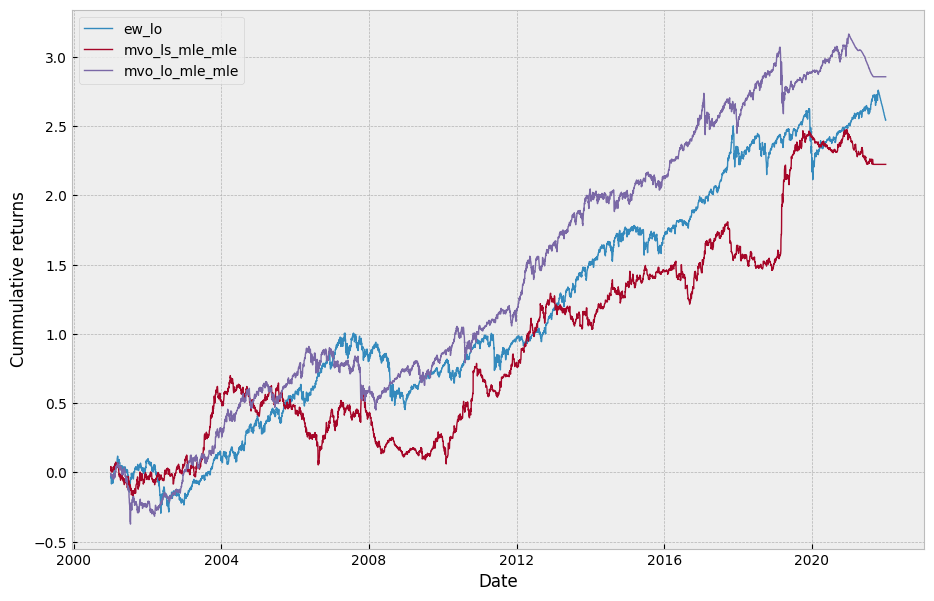

In [103]:
fig, ax = plt.subplots(figsize=(11, 7))
for model in model_names:
    summary_df = all_summary_df.loc[all_summary_df["id"] == model]

    portfolio_returns =  summary_df.groupby("date").sum()[["pnl"]]
    portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
    portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()

    cum_pnl_df = portfolio_returns_target.cumsum().reset_index()
    ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df["pnl"], label=model)

plt.xlabel("Date")
plt.ylabel("Cummulative returns")
plt.legend(loc='best', fontsize=10)   
# fig.savefig(os.path.join(results_path, "all_cummulative_returns_ls.png"), dpi=300)
plt.show()

## Check Weights

<Axes: xlabel='date'>

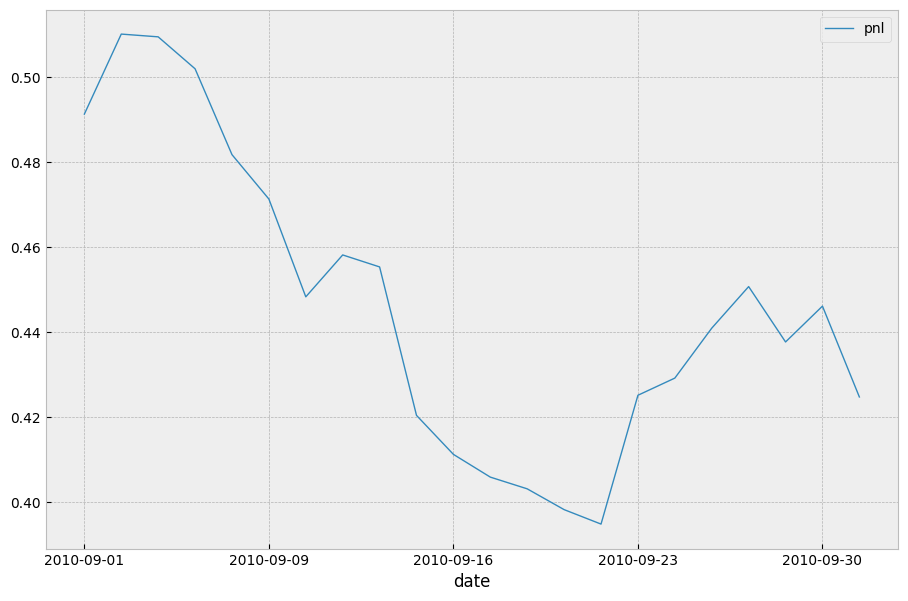

In [92]:
model = 'mvo_ls_mle_mle'

summary_df = all_summary_df.loc[all_summary_df["id"] == model]

portfolio_returns =  summary_df.groupby("date").sum()[["pnl"]]
portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()

cum_pnl_df = portfolio_returns_target.cumsum()

cum_pnl_df.loc["2010-09-01":"2010-10-01"].plot(figsize=(11, 7))

In [83]:
check_df = summary_df.loc[(summary_df['date'] >= '2010-09-01')&(summary_df['date'] <= '2010-10-01')]
returns_check_df = check_df.pivot_table(index=['date'], columns=['ticker'], values=['returns'])
returns_check_df["sum"] = returns_check_df.sum(axis=1)
weights_check_df = check_df.pivot_table(index=['date'], columns=['ticker'], values=['weights'])
weights_check_df['sum'] = weights_check_df.sum(axis=1)

In [84]:
returns_check_df.loc['2010-09-23':'2010-09-30']

returns                                                    \
ticker           SPY       XLB       XLE       XLF       XLI       XLK   
date                                                                     
2010-09-23 -0.029458 -0.045225 -0.041603 -0.049521 -0.041349 -0.014883   
2010-09-24 -0.032324 -0.056092 -0.056448 -0.028571 -0.037492 -0.031033   
2010-09-27  0.006025 -0.001651 -0.010785  0.010381  0.010341  0.011378   
2010-09-28  0.023780  0.032077  0.036457  0.044521  0.025247  0.012500   
2010-09-29  0.011184  0.020827  0.014629  0.004918  0.017637  0.012757   
2010-09-30 -0.020376 -0.044225 -0.032723 -0.028956 -0.025507 -0.014222   

                                                         sum  
ticker           XLP       XLU       XLV       XLY            
date                                                          
2010-09-23 -0.020561 -0.018378 -0.026962 -0.032267 -0.320207  
2010-09-24 -0.018994 -0.016939 -0.020237 -0.030036 -0.328166  
2010-09-27  0.002038  0.009976  0.000318  0.015057  0.053078  
2010-09-28  0.019322  0.008081  0.016518  0.023510  0.242013  
2010-09-29  0.005986  0.003563  0.015313  0.006836  0.113650  
2010-09-30 -0.018843 -0.010059 -0.017236 -0.017110 -0.229257

In [85]:
weights_check_df.loc['2010-09-23':'2010-09-30']

weights                                                    \
ticker           SPY       XLB       XLE       XLF       XLI       XLK   
date                                                                     
2010-09-23  0.429180  0.550715  0.928499  0.278687  0.492285  0.808362   
2010-09-24  0.267386 -0.069466  0.005097 -0.097777  0.084574  0.044584   
2010-09-27 -0.500000  0.006122  0.069728  0.067555  0.061709  0.107764   
2010-09-28  0.176901  0.031418 -0.061941 -0.057523  0.151637 -0.189247   
2010-09-29 -0.500000  0.004013  0.069948  0.067633  0.063879  0.106182   
2010-09-30 -0.500000  0.012228  0.063810  0.072101  0.068319  0.101281   

                                                             sum  
ticker           XLP       XLU       XLV       XLY                
date                                                              
2010-09-23  0.705629  0.003532  0.815064  0.104926  5.116879e+00  
2010-09-24  0.098360 -0.113661 -0.137091 -0.082004 -2.200000e-08  
2010-09-27  0.054300  0.026065  0.055790  0.050968 -2.000000e-09  
2010-09-28  0.050240 -0.094441  0.089804 -0.096847  5.000000e-09  
2010-09-29  0.054769  0.025174  0.056684  0.051718  1.700000e-09  
2010-09-30  0.043564  0.031792  0.066783  0.040122  4.000000e-09

<Axes: xlabel='date'>

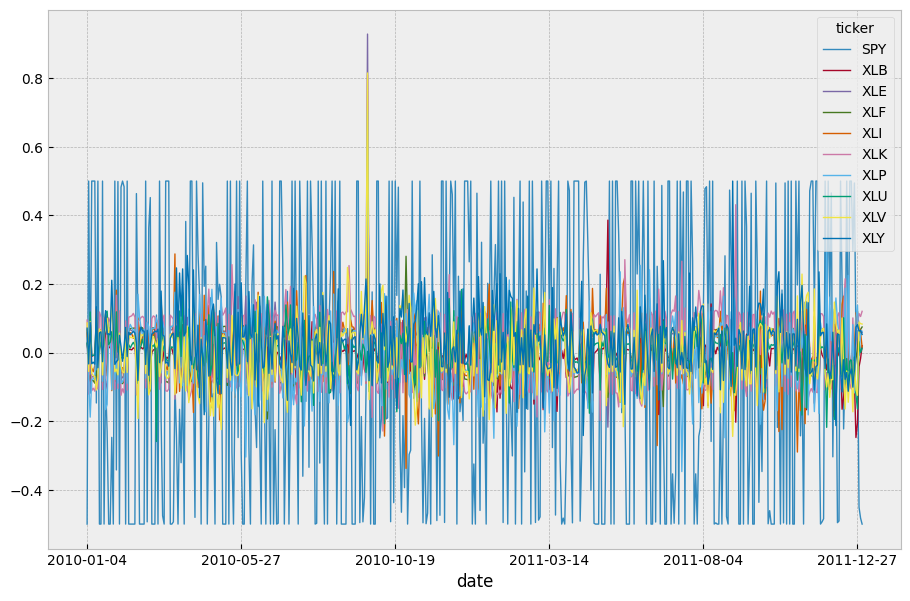

In [62]:
model = "mvo_ls_mle_mle"
summary_df = all_summary_df.loc[all_summary_df["id"] == model]

pivot_summary_df = summary_df[["date", "ticker", "weights"]].pivot_table(index="date", columns="ticker", values="weights").loc["2010-01-01":"2012-01-01"]

pivot_summary_df.plot(figsize=(11, 7))

## 3) Boxplot with the Sharpe Ratio for each Monte Carlo Sample

## 4) Forecast Comparison - Diebold-Mariano Test